![PyTorch Logo](images/pytorch1.png)

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

We will use not only basic functionlaity of `pytorch` but also **`torchvision`** computer vision library.

In [2]:
!pip freeze 2>/dev/null | grep torch

torch==1.2.0
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.4.0


# Pytorch as a constructor

## Working with datasets

For data loading pytorch defines **`Dataset`** entity.

This abstract class is defined in `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
One should inherit `Dataset` and implement `__getitem__` and `__len__` nethods to create a new data source.

An example of such ancestor — `torchvision.datasets.ImageFolder`, which allows us to use imagenet-like dataset based on a directory with `./train/{class}` and `./val/{class}` sub-directories structure:

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Custom example — a dataset loading images with classes defined in some text file:

In [0]:
from torch.utils.data import Dataset
# default_loader - default image loading function, uses accimage or PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [5]:
catdog = TxtList('/tmp/dataset.tsv')

=> Found 4 entries in /tmp/dataset.tsv


IndexError: ignored

In [0]:
catdog.classes

In [0]:
catdog.imgs

In [0]:
len(catdog)

In [0]:
# FileNotFoundError
catdog[0]

`torchvision` has another useful classes for using standard datasets: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Some of them can be preloaded with built-in functionality, for example **MNIST**:

In [0]:
![ -d '/tmp/mnist/' ] && rm -r '/tmp/mnist/'

In [0]:
from torchvision.datasets import MNIST

%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

In [0]:
len(mnist)

In [0]:
type(mnist)

In [0]:
image, target = mnist[0]
print(target)

In [0]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Hometask!</font>

Implement **`UrlList`** dataset which costructor takes list of urls as a parameter.

In [0]:
#stackOF
from typing import List
from PIL import Image
import requests

link = ['https://lh3.googleusercontent.com/OQQ32egOR5EBOxMQNgjZlyDd7WZo-suAxnvsGdo2P6nR6Ns3wKyWvbxQ9it4DCQRxecIsw=s106' ,
       'https://avatars.mds.yandex.net/get-pdb/966350/933f1b2c-a3fc-4bce-82c5-693ebaf7b6db/s1200']
p = requests.get(link,  stream=True)
out = open("./data/1.jpg" , "wb")
out.write(p.content)
out.close()


In [0]:
from typing import List
import requests



class UrlList(Dataset):
    def __init__(self, urls: List[str]):
        self.imgs = []
        for link in urls:
            p = np.array(Image.open(requests.get(link, stream=True).raw))
            self.imgs.append(p)

    
    
    def __getitem__(self, index):
        return self.imgs[index]

    def __len__(self):
        return len(self.imgs)

Demonstrate how it works with some examples:

In [0]:
img = UrlList(link)

In [0]:
plt.imshow(np.array(img[0]))
plt.show()
plt.imshow(np.array(img[1]))
plt.show()

## Data transformation

In the example shown before and in built-in `ImageFolder` `__init__` methods has `transform` parameter (and `target_transform`).

They are used to transform images/targets loaded into predefined range and form.

There is `transforms` sub-module in `torchvision` library which has some examples of such transforms:

In [0]:
from torchvision import transforms

For example `transforms.ToTensor()` transforms uint8 `PIL` [0, 256)-domained images into [0, 1)-domained tensors.

In [0]:
to_tensor = transforms.ToTensor()

In [0]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

One can define `normalize` to implement a standard ImageNet preparation step:

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

`transforms.Compose` is used to sequence several compositions as a whole:

In [0]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

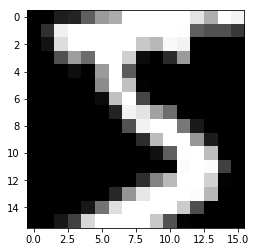

In [0]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

To define a custom transformer we should only implement `__call__` method its implementation:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

It is adviced to take a glance at http://pytorch.org/docs/master/torchvision/transforms.html for standard transformations overview.

## Optional reading

Another example of a good set of pre-defined transformations is [`albumentations`](https://github.com/albu/albumentations) library.

It supports not only image transformations but it can simultaniously transform its corresponding masks and bboxes.

One can also use [`imgaug`](https://github.com/aleju/imgaug) augmentations library but needs to implement `imguag output` -> `tensor` transformations on their own.

## <font color='#cc6666'>Hometask!</font>

Implement a transformer that applies random transformation from $D_4$ transformations group.

These transformations are very usefull for lossless augmentations in satellite images analysis.

In [0]:
from PIL import Image
class RandomD4(object):
    def __call__(self, img):
        deg = np.random.choice([0,90,180,270])
        ret = img.rotate(deg)
        mirror = np.random.choice([0,1])
        if mirror:
            ret = img.transpose(Image.FLIP_LEFT_RIGHT)
        return ret

Demonstrate how it works on some MNIST images:

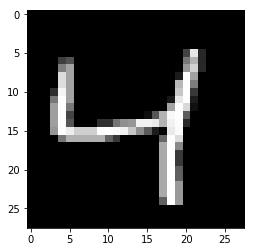

In [0]:
plt.imshow((mnist[2][0]),'gray')
plt.show()

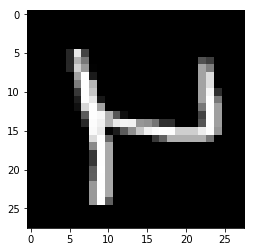

In [0]:
plt.imshow(RandomD4()(mnist[2][0]),'gray')
plt.show()

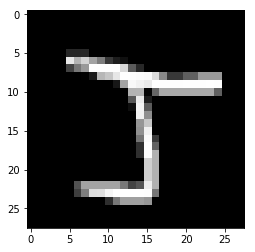

In [0]:
plt.imshow(RandomD4()(mnist[2][0]),'gray')
plt.show()

## Data loaders

The main reason to implement `Dataset` class is a magic power of `torchvision` loaders:

In [0]:
from torch.utils.data import DataLoader

The loaders are built on top of some dataset and allow batch iterating over it.

Those batches in their turn are created with applying the transformations defined in background processes.

Let's look at MNIST dataset with a simple transformer applied as loaders use tensors and not `PIL.Image`s.

In [0]:
transformed_mnist = MNIST('/tmp/mnist/', train=True, transform=transforms.ToTensor())

In [0]:
mnist_loader = DataLoader(transformed_mnist, batch_size=8, shuffle=True, num_workers=4)  # shuffle note here

DataLoader standard parameter values are shown above.

One can also add **`pin_memory=True`** to page-lock the memory thus making faster cpu-to-cuda transfer with a non-blocking option.

**`drop_last=True`** is for avoiding batches size skew in the training process.

Let us demonstrate how it works:

In [0]:
for images, targets in tqdm(mnist_loader):
    pass

100%|████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:04<00:00, 1598.41it/s]


There are image batches as tensors on the output:

In [0]:
images.shape

torch.Size([8, 1, 28, 28])

In [0]:
targets.shape

torch.Size([8])

The loader instance pre-calculate the total number of batches (what makes `tqdm` happy):

In [0]:
len(mnist_loader)

7500

Some data example (will be random on each run):

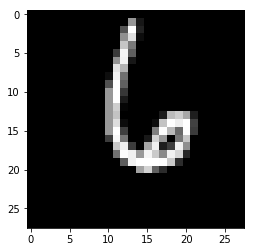

In [0]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [0]:
print(targets[0])

tensor(6)


## Building NN models

We should inherit `torch.nn.Module` class to implement pytorch model, `torch.nn` has lots of pre-defined "building bricks".

Their functional analogs are collected in `torch.nn.functional`.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

We have both module and functional versions of max-pooling, activations, upsempling and some other ops:
* `nn.MaxPool2d` / `F.max_pool2d`
* `nn.ReLU` / `F.relu`
* `nn.Upsample(mode='bilinar')` / `F.upsample(mode='bilinar')` — **deprecated**, use `F.interpolate` instead

To compose several nn modules we can use `nn.Squential`:

In [0]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Models training

To train a model one must define a looss functions, some of them can also be found in `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = torch.arange(1, 1001)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

We can update the weights manually:

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Or use built-in optimizer from `torch.optim` family:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

We need to zero the gradients to disable gradient accumulations that happens by defult (`pytorch` sends its regards to `tf` rnn implementations):
```python
optimizer.zero_grad()
```

After zeroing the gradients we can run both forward and backward stage with loss calculation in-between:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

To update the weights we can use the optimizer again:
```python
optimizer.step()
```

To adjust learning rate in some pre-defined way we can use **`torch.optim.lr_scheduler`** sub-module:
```python
from torch.optim import lr_scheduler
```

To train ResNets on ImageNet with a standard training scheme we can use
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
    # no scheduler.step() here* 
    # train(...)
    # validate(...)
    scheduler.step()  # == scheduler.step(epoch)
```
\* one **should not** put `scheduler.step()` before `optimizer.step()`, otherwise the first epoch will be "skipped".

## Optional reading

There are several libraries out there like [`catalyst`](https://github.com/catalyst-team/catalyst) or [`kekas`](https://github.com/belskikh/kekas) that make building pipelines even easier.

# Pytorch in the wils

## Segmentation model creation (with U-Net as an example)

![U-Net scheme](images/unet.png)

In [0]:
import torch
from torch import nn

Pre-defined heavily-used convolutions:

In [0]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

One **encoder block** consists of two sequential convolutions, an activation layer and an optional batch-norm:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [0]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Alternative definition:

In [0]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [0]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


And its "functional" version:

In [0]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [0]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [0]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 64, 128, 128])


Encoder is composed from several encoder blocks.

Its final form is defined bu the number of input channels, the number of channels in the first block output and the number of such blocks.

And we need to store preliminary activatons to apply Decoder on.

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Here we can use **`add_module`** way of layers definition as its number is variable.

In [0]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(32, 64, kernel_s

In [0]:
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Decoder block consists of upscaling "lower" output and concatenating it with a saved encoder block output from the "left".

In [0]:
Upsample = nn.Upsample

# class Upsample(nn.Module):
#     def __init__(self, scale_factor=2, mode='bilinear'):
#         super().__init__()

#         self.scale_factor = scale_factor
#         self.mode = mode

#     def forward(self, x):
#         return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=True)

class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [0]:
block = DecoderBlock(8)

In [0]:
y = encoder(x)

In [0]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [0]:
block(y[1], y[0]).shape

C:\Apps\anaconda3\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 8, 512, 512])

Let us build Decoder from several decoder blocks:

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [0]:
decoder = Decoder(8, 3)

In [0]:
x.shape

torch.Size([4, 3, 512, 512])

In [0]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [0]:
decoder(encoder(x)).shape

torch.Size([4, 8, 512, 512])

U-Net is build from Encoder, Decoder and a final classification layer:

In [0]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Integration testing" (pytorch 0.3 legacy code):

In [0]:
from torch.autograd import Variable

model = UNet(num_classes=1)
#if torch.cuda.is_available():
 #   model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
#if torch.cuda.is_available():
#    images = images.cuda()

model.forward(images).shape

=> Building 4-blocks 64-filter U-Net


C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1594884096 bytes. Buy new RAM!


```
/home/nizhib/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/nizhib/.anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
```

ModuleNotFoundError: No module named 'Tkinter'

Same for **pytorch 0.4+**:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(num_classes=1)
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)

with torch.no_grad():
    print(model.forward(images).shape)

=> Building 4-blocks 64-filter U-Net


RuntimeError: CUDA out of memory. Tried to allocate 170.00 MiB (GPU 0; 4.00 GiB total capacity; 2.79 GiB already allocated; 122.77 MiB free; 40.76 MiB cached)

We get linear activations as an output.

To train such models we need to use **/.\*WithLogits/** loss functions subset

We can use `torch.sigmoid` or `torch.softmax` to get probabilities (**0.4.1+**, `torch.nn.functional.sigmoid/softmax` before)

## Using pretrained encoder

Encoder blocks structure seen before looks exactly like VGG architecture:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Let us have a look at VGG model from `torchvision` library:

In [0]:
from torchvision.models import vgg13

VGG13 is the VGG version with 2 convolutional layer in each block:

In [0]:
model = vgg13()

In [0]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

We don't need the classifier, only the features are useful.

They are built from conv-relu-conv-relu + maxpooling.

Let's build encoder blocks via grouping VGG layers:

In [0]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [0]:
vgg_encoder = VGG13Encoder(num_blocks=4, pretrained=False)
vgg_encoder

VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequenti

Compare it to "vanilla" encoder:

In [0]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): Sequential(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block4): Sequential(
    (conv1): Conv2d(256, 

Both structures are identical!

But now we have some usefull pretrained weights in the decoder.

## <font color='#cc6666'>Hometask!</font>

### Part1. Toy dataset


**Implement** toy dataset to generate noisy ellipses like that:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

The dataset should output both the image and its corresponding mask.

In [0]:
class Ellipses(Dataset):
    pass

In [0]:
radius = np.random.random(NUM)*2
radius //= 1
radius += 1
radius

NameError: name 'NUM' is not defined

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def generator_P(P):
    NUM = np.random.randint(10)+1
    size = 512
    rad_size =  5 +np.random.randint(size//4)
    radius = np.random.random(NUM)*rad_size
    radius //= 1
    radius += 1
    bg = np.random.random(size=(1,3))
    #print(radius)
    clr = np.random.random(size=(NUM,3)) 
    #print(clr)
    x = np.random.random(NUM)*(size - 2*rad_size)
    x //= 1
    x += 1
    y = np.random.random(NUM)*(size - 2*rad_size)
    y //= 1
    y += 1
    mask = np.zeros((size,size))
    img = np.ones((size,size,3))
    img -= bg 
    for k in range(NUM):
        for i in range(2*int(radius[k])):
            for j in range (2*int(radius[k])):
                if (((radius[k] - i -1 )**2 + (radius[k] - j -1)**2) < (radius[k] -1)**2) :
                    mask[x[k] + i][y[k] + j] = 1
                    for h in range(3):
                        img[x[k] + i][y[k] + j][h] = clr[k][h]



    #mask[3:-3, 4:-3] = 1 # white square in black background
    img +=  np.random.randn(size,size,3) * 0.1 # random image
    #masked = np.ma.masked_where(mask == 0, mask)
    
    
    #print(img)
    cmap = plt.cm.RdYlBu
    plt.figure(figsize = (15,15) , dpi = 70)
    plt.imshow(mask, 'gray', interpolation='none')
    #plt.show()
    plt.savefig('./data/mask/{}.png'.format(P))
    plt.figure(figsize = (15,15) , dpi = 70)
    plt.imshow(img, 'gray', interpolation='gaussian'  )
    #plt.imshow(masked, 'Blues', interpolation ='nearest' , alpha=1)
    plt.savefig('./data/img/{}.png'.format(P))
    plt.show()


Define utility function:

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


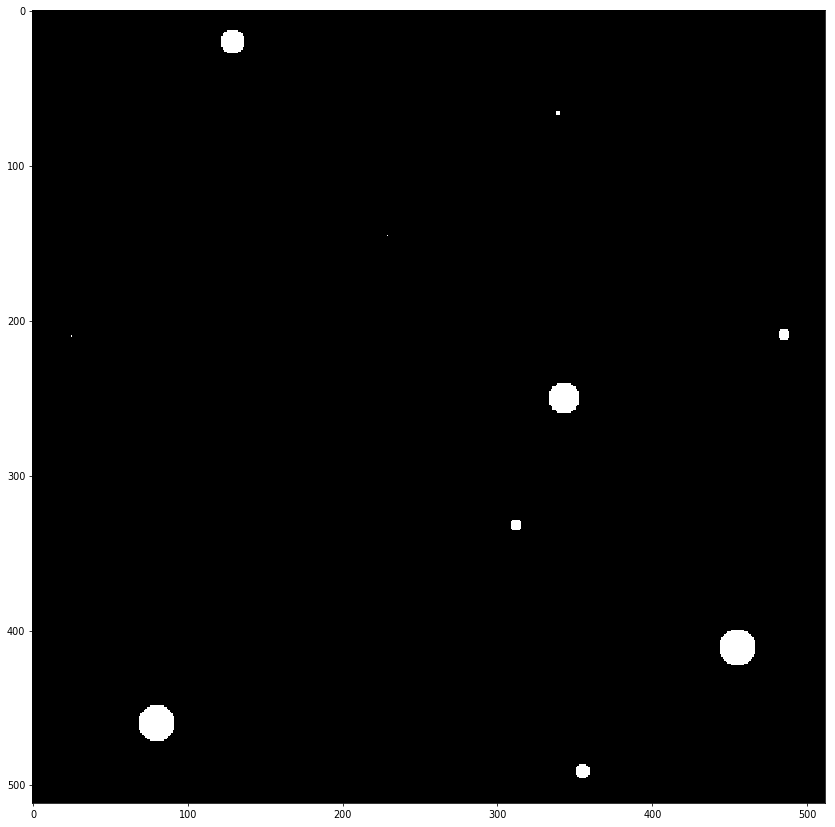

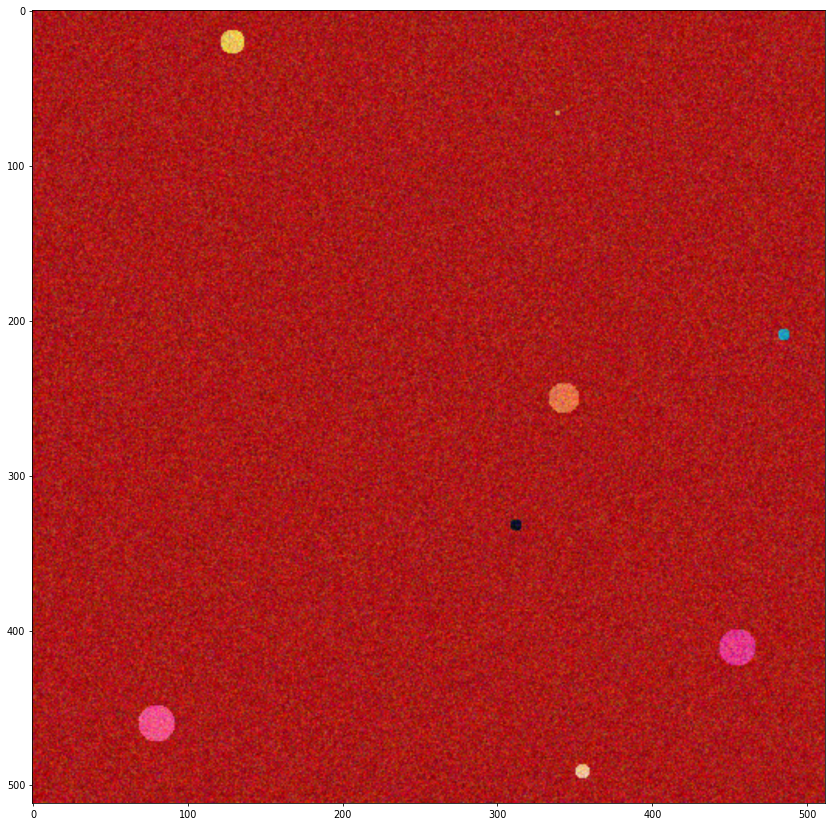

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


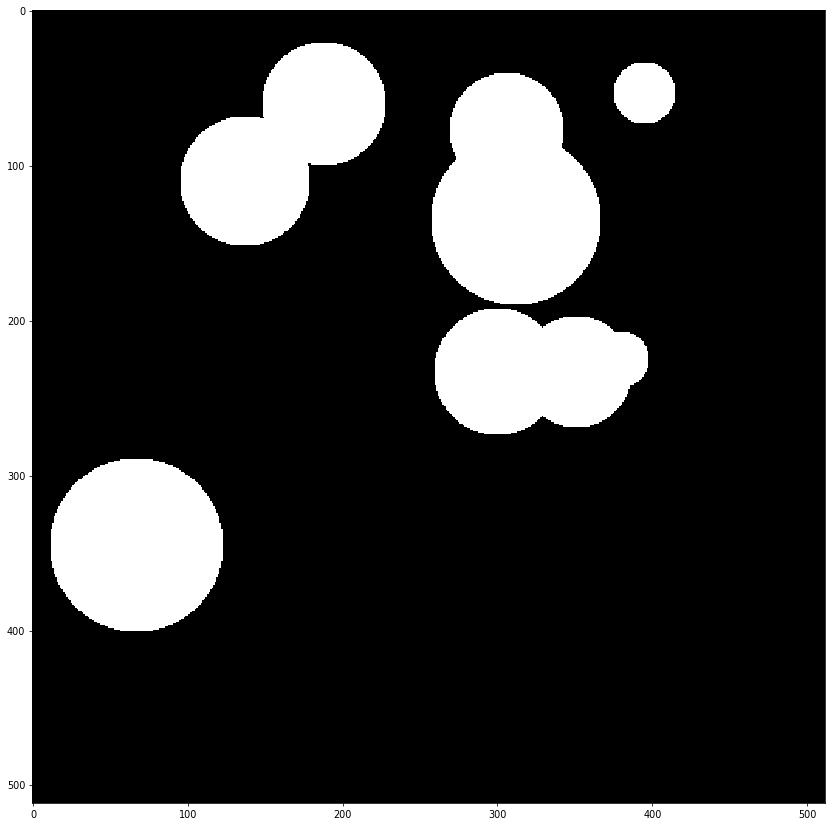

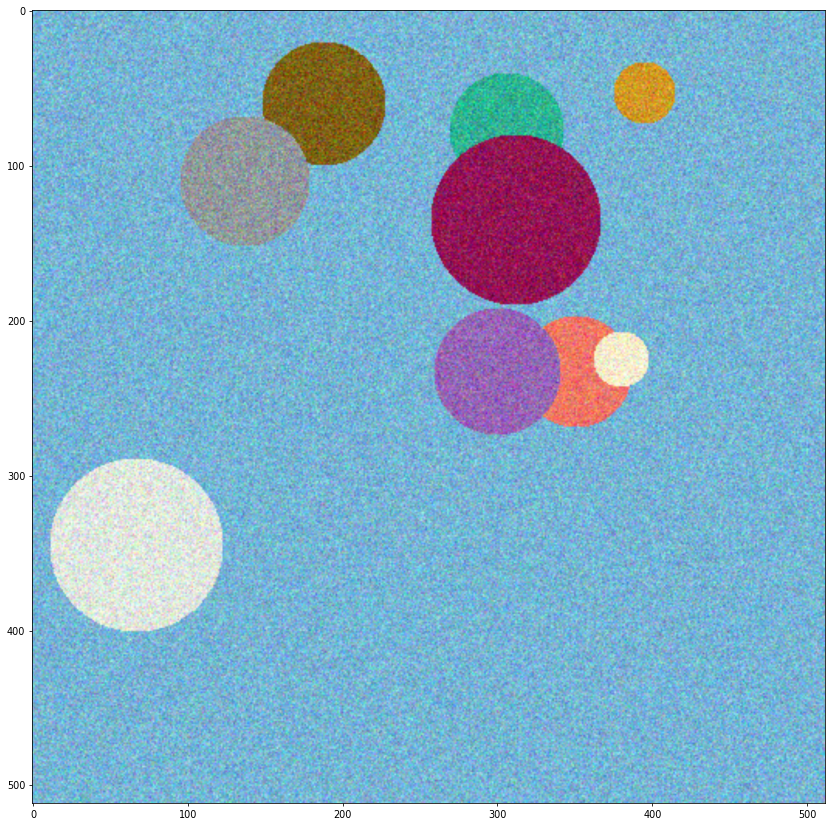

In [0]:
for i in range(2):
    generator_P(i)

In [1]:
import hashlib

def moy_variant(surname):
    return int(hashlib.md5(surname.encode().lower()).hexdigest()[-1], 16) % 2

In [2]:
moy_variant('аминов')

1

**Implement ACFNet** (https://arxiv.org/abs/1909.09408, if `moy_variant` returns 1 for you) **or OCRNet** (https://arxiv.org/abs/1909.11065, otherwise) based on pretrained **DenseNet** (pytorch) and **DPN** (cadene/pretrainedmodels) networks instead of ResNets from the papers.

It is advised to use `BCEWithLogitsLoss` as a loss function.

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
class ACFDenseNet(nn.Module):
    def __init__(self, num_classes, backbone='densenet161'):
        super().__init__()
        self.num_classes = num_classes
        model = models.densenet121(pretrained=True)
        self.densenet = model.features #срезали классификацию
        self.conv_tr2 = nn.Conv2d(256,128,1)
        self.conv_tr3 = nn.Conv2d(1024,128,1)
        self.coarse_final = nn.Conv2d(128,num_classes,1)
        self.conv2 = nn.Conv2d(128,128,1)
        self.conv_final = nn.Conv2d(256,num_classes,1)
        self.softmax = nn.Softmax2d()

    def forward(self, x):
        # поттягиваем слои большего разрешения для того чтобы уточнить маску
        for mod in self.densenet.named_children():
            x = mod[1].forward(x)
            if mod[0] == "transition1":
                x_64 = x
            if mod[0] == "transition2":
                x_32 = self.conv_tr2(x)
        #склеиваем то что получилось
        x = self.conv_tr3(x)
        x =  nn.functional.interpolate(x,scale_factor=2, mode='bilinear')
        x += x_32
        x = nn.functional.interpolate(x,scale_factor=2, mode='bilinear')
        x += x_64
        x = nn.functional.interpolate(x,scale_factor=8, mode='bilinear')
        
        
        coarse_seg = self.coarse_final(x)
        coarse_seg_reshaped = coarse_seg.reshape(x.shape[0],self.num_classes,-1)
        x_reshaped = x.reshape(x.shape[0],x.shape[1],-1).permute(0,2,1)
        F_class = coarse_seg_reshaped.matmul(x_reshaped).permute(0,2,1)
        F_a = F_class.matmul(coarse_seg_reshaped).reshape(x.shape)
        F_a = self.conv2(F_a)
        x = torch.cat((x,F_a),dim = 1)
        x = self.conv_final(x)

        return self.softmax(x)

class ACFDPN(nn.Module):
    def __init__(self, num_classes, arch='dpn92'):
        super().__init__()
        self.num_classes = num_classes
        model = pretrainedmodels.dpn92(num_classes=1000, pretrained='imagenet+5k')
        self.densenet = model.features
        self.conv_tr1 = nn.Conv2d(512+192,128,1)
        self.conv_tr2 = nn.Conv2d(1024+528,128,1)
        self.conv_tr3 = nn.Conv2d(2688,128,1)
        self.coarse_final = nn.Conv2d(128,num_classes,1)
        self.softmax_coarse = nn.Softmax2d()
        self.conv2 = nn.Conv2d(128,128,1)
        self.conv_final = nn.Conv2d(256,num_classes,1)
        self.softmax_final = nn.Softmax2d()
        

    def forward(self, x):
        for mod in self.densenet.named_children():
            x = mod[1].forward(x)
            if mod[0] == "conv3_4":
                x_64 = self.conv_tr1(torch.cat((x[0],x[1]),dim=1))
            if mod[0] == "conv4_20":
                x_32 = self.conv_tr2(torch.cat((x[0],x[1]),dim=1))
        
        x = self.conv_tr3(x)
        x =  nn.functional.interpolate(x,scale_factor=2, mode='bilinear')
        x += x_32
        x = nn.functional.interpolate(x,scale_factor=2, mode='bilinear')
        x += x_64
        x = nn.functional.interpolate(x,scale_factor=8, mode='bilinear')
        coarse_seg = self.coarse_final(x)
        
        coarse_seg_reshaped = coarse_seg.reshape(x.shape[0],self.num_classes,-1)
        x_reshaped = x.reshape(x.shape[0],x.shape[1],-1).permute(0,2,1)
        F_class = coarse_seg_reshaped.matmul(x_reshaped).permute(0,2,1)
        F_a = F_class.matmul(coarse_seg_reshaped).reshape(x.shape)
        F_a = self.conv2(F_a)
        x = torch.cat((x,F_a),dim = 1)
        x = self.conv_final(x)
      
        return self.softmax_final(x)


class OCRDenseNet(nn.Module):
    def __init__(self, num_classes, arch='densenet161'):
        pass

    def forward(self, x):
        pass


class OCRDPN(nn.Module):
    def __init__(self, num_classes, arch='dpn92'):
        pass

    def forward(self, x):
        pass

**Demonstrate** how they are trained with `tensorboard` screenshots (use `tensorboardX` library).

That includes but not limited to loss curves, masks from different epochs etc.

### Part2. Portrait Segmentation

Repeat the training procedures on some real task: http://xiaoyongshen.me/webpage_portrait/.

Easy-to-use dataset version can be downloaded from https://yadi.sk/d/1SSkfLh4WnEhmw.

Use `dice score` as a target scoring function, it should be published in the final report.

All the loss charts, mask quality evolution and final mask examples are expected as well.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
images_path ='/content/gdrive/My Drive/ellips/img'
masks_path ='/content/gdrive/My Drive/ellips/mask'


In [0]:
#к сожалению во время обучения мы сталкнулись с проблемой нехватки видео памяти на колабе

In [0]:
#так как картинки лиц не одинакового размера мы превращаем их в 512х512
def face_transform(img):
    t1 = torchvision.transforms.ToTensor()
    t2 = torchvision.transforms.Resize((512,512))
    return t1(t2(img)) #порядок кстати менять нельзя)

In [0]:
#датасет для загрузки портреов (эллипсов)
class Face_dataset(Dataset):
    def __init__(self,mask_path,img_path):
        self.images = torchvision.datasets.ImageFolder(img_path,transform=face_transform)
        self.masks = torchvision.datasets.ImageFolder(mask_path,transform=face_transform)
    def __getitem__(self,index):
        return (self.images[index][0], self.masks[index][0])
    def __len__(self):
        return len(self.images)

In [0]:
data = Face_dataset(masks_path,images_path)

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [39]:
!nvidia-smi #выводит информацию о видеокарте

Tue Oct 15 18:44:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    57W / 149W |   8099MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!kill 0 #это единственный способ который я нашел для очищения видеопамяти

In [0]:
model = ACFDenseNet(2).to(device)

In [28]:
#разделяем все на трейн и тест STACKOF

train_ind = np.arange(100) #размер трейна
test_ind = np.arange(100,150) # размер теста

train_sampler = SubsetRandomSampler(train_ind)
test_sampler = SubsetRandomSampler(test_ind)
train_loader = DataLoader(data,batch_size = 5,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(data,batch_size = 5,sampler=test_sampler,num_workers=1)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adadelta(model.parameters(),lr=0.004)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = [10],gamma = 0.1)


NameError: ignored

In [0]:
criterion = criterion.to(device)

In [0]:
#c tensorboardX возникли проблемы (и даже TensorBoardColab() не помог поэтому запоминал  и строил все ошибки руками ) 

In [0]:
def image_logs(model,data,epoch):
    img_tr = data[0][0]
    image_from_train = data[0][0].unsqueeze(0).to(device)
    mask_from_train = data[0][1].unsqueeze(0).to(device)
    image_from_test = data[130][0].unsqueeze(0).to(device)
    mask_from_test = data[130][1].unsqueeze(0).to(device)
    tr = torchvision.transforms.ToPILImage()
    img_tr = tr(data[0][0].detach())
    img_te = tr(data[130][0].detach())
    mask_tr = tr(data[0][1].detach())
    mask_te = tr(data[130][1].detach())
    img_tr.save('/content/gdrive/My Drive/img_logs/img_tr.jpg')
    img_te.save('/content/gdrive/My Drive/img_logs/img_te.jpg')
    mask_tr.save('/content/gdrive/My Drive/img_logs/mask_tr.jpg')
    mask_te.save('/content/gdrive/My Drive/img_logs/mask_te.jpg')
    with torch.no_grad():
        pred_mask_train = tr(model.forward(image_from_train)[0][0].cpu().detach())
        pred_mask_test = tr(model.forward(image_from_test)[0][0].cpu().detach())
    pred_mask_train.save('/content/gdrive/My Drive/img_logs/pred_mask_tr{}.jpg'.format(epoch))
    pred_mask_test.save('/content/gdrive/My Drive/img_logs/pred_mask_te{}.jpg'.format(epoch))

In [0]:
#STOF
def dice(input, target):
    smooth = 1.

    iflat = input.reshape(-1)
    tflat = target.reshape(-1)
    intersection = (iflat * tflat).sum()

    return ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
  

In [0]:
model = ACFDenseNet(2)
model.load_state_dict(torch.load('/content/gdrive/My Drive/saves/_net_32.pwf'))
model = model.to(device)

In [33]:
num_epoch = 45
train_error = []
test_error = []
train_dice = []
test_dice = []
for epoch in range(num_epoch):
  train_dice.append(0.)
  train_error.append(0.)
  model.train()
  for batch,(images, masks) in enumerate(train_loader):
    images, masks = images.to(device), masks.to(device)
    optimizer.zero_grad()
    pred = model.forward(images)
    loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
    loss.backward()
    optimizer.step()
    

    with torch.no_grad():
      train_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
    train_error[epoch] += loss.item()
    if batch % 10 == 0:
      print ("error at batch {}: train = {}, dice = {}".format(batch,train_error[epoch]/(batch+1),train_dice[epoch]/(batch+1)))
  image_logs(model,data,epoch)
  scheduler.step()
  train_error[epoch] /= len(train_loader)
  train_dice[epoch] /= len(train_loader)
  test_dice.append(0.)
  test_error.append(0.)
  
  with torch.no_grad():
    for (images, masks) in test_loader:
      model.eval()
      images, masks = images.to(device), masks.to(device)
      pred = model.forward(images)
      loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
      test_error[epoch] += loss.item()
      test_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
  test_error[epoch] /= len(test_loader)
  test_dice[epoch] /= len(test_loader)
  
  
  print("error at epoch {}: train = {}, test = {}".format(epoch,train_error[epoch],test_error[epoch]))
  print("dice at epoch {}: train = {}, test = {}".format(epoch,train_dice[epoch],test_dice[epoch]))
  
  torch.save(model.state_dict(), "/content/gdrive/My Drive/saves/_net_{}.pwf".format(epoch))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


error at batch 0: train = 0.5264155268669128, dice = 0.9805871844291687
error at batch 10: train = 0.5210681882771578, dice = 0.9810768365859985
error at epoch 0: train = 0.5192953959107399, test = 0.5218357920646668
dice at epoch 0: train = 0.97979736328125, test = 0.9815155863761902
error at batch 0: train = 0.528602123260498, dice = 0.9847899079322815
error at batch 10: train = 0.518859164281325, dice = 0.9801441431045532


KeyboardInterrupt: ignored

In [0]:
#оставил только логи с последней итерации остальные в файле с фото

In [34]:
num_epoch = 45
train_error = []
test_error = []
train_dice = []
test_dice = []
for epoch in range(num_epoch):
    train_dice.append(0.)
    train_error.append(0.)
    model.train()
    for batch,(images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        pred = model.forward(images)
        loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
        loss.backward()
        optimizer.step()
    

    with torch.no_grad():
        train_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
    train_error[epoch] += loss.item()
    if batch % 10 == 0:
        print ("error at batch {}: train = {}, dice = {}".format(batch,train_error[epoch]/(batch+1),train_dice[epoch]/(batch+1)))
    image_logs(model,data,epoch)
    scheduler.step()
    train_error[epoch] /= len(train_loader)
    train_dice[epoch] /= len(train_loader)
    test_dice.append(0.)
    test_error.append(0.)
  
    with torch.no_grad():
        for (images, masks) in test_loader:
            model.eval()
            images, masks = images.to(device), masks.to(device)
            pred = model.forward(images)
            loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
            test_error[epoch] += loss.item()
            test_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
    test_error[epoch] /= len(test_loader)
    test_dice[epoch] /= len(test_loader)


    print("error at epoch {}: train = {}, test = {}".format(epoch,train_error[epoch],test_error[epoch]))
    print("dice at epoch {}: train = {}, test = {}".format(epoch,train_dice[epoch],test_dice[epoch]))

    torch.save(model.state_dict(), "/content/gdrive/My Drive/saves/dpn_net_{}.pwf".format(epoch))

FileNotFoundError: ignored

In [0]:
model = ACFDenseNet(2).to(device)

In [0]:
model = ACFDenseNet(2)
model.load_state_dict(torch.load('/content/gdrive/My Drive/saves/net_39.pwf')) #Выгружаем состояние сети 
model = model.to(device)

In [31]:
!pip install pretrainedmodels


     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=6488b62276f84a6a59eb6cfa421d4936588f4f69091ea87ecacafed8560db661
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=a59e16509b8fde92ebb81a623f04de6d0b64de2d4520ade3088a9a2c1eb4d203
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built pretrainedmodels munch


In [0]:
import pretrainedmodels
model = ACFDPN(2).to(device)
train_ind = np.arange(100)
test_ind = np.arange(100,150)

train_sampler = SubsetRandomSampler(train_ind)
test_sampler = SubsetRandomSampler(test_ind)
train_loader = DataLoader(data,batch_size = 4,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(data,batch_size = 4,sampler=test_sampler,num_workers=1)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adadelta(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = [10],gamma = 0.1)
criterion = criterion.to(device)

In [15]:
num_epoch = 45
train_error = []
test_error = []
train_dice = []
test_dice = []
for epoch in range(num_epoch):
  train_dice.append(0.)
  train_error.append(0.)
  model.train()
  for batch,(images, masks) in enumerate(train_loader):
    images, masks = images.to(device), masks.to(device)
    optimizer.zero_grad()
    pred = model.forward(images)
    loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
    loss.backward()
    optimizer.step()
    

    with torch.no_grad():
      train_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
    train_error[epoch] += loss.item()
    if batch % 10 == 0:
      print ("error at batch {}: train = {}, dice = {}".format(batch,train_error[epoch]/(batch+1),train_dice[epoch]/(batch+1)))
  image_logs(model,data,epoch)
  scheduler.step()
  train_error[epoch] /= len(train_loader)
  train_dice[epoch] /= len(train_loader)
  test_dice.append(0.)
  test_error.append(0.)
  
  with torch.no_grad():
    for (images, masks) in test_loader:
      model.eval()
      images, masks = images.to(device), masks.to(device)
      pred = model.forward(images)
      loss = criterion(pred[:,0,:,:],masks[:,0,:,:])
      test_error[epoch] += loss.item()
      test_dice[epoch] += dice(pred[:,0,:,:],masks[:,0,:,:]).cpu()
  test_error[epoch] /= len(test_loader)
  test_dice[epoch] /= len(test_loader)
  
  
  print("error at epoch {}: train = {}, test = {}".format(epoch,train_error[epoch],test_error[epoch]))
  print("dice at epoch {}: train = {}, test = {}".format(epoch,train_dice[epoch],test_dice[epoch]))
  
  torch.save(model.state_dict(), "/content/gdrive/My Drive/saves/dpn_net_{}.pwf".format(epoch))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


error at batch 0: train = 0.5929418802261353, dice = 0.7711139917373657
error at batch 10: train = 0.5697792334990068, dice = 0.8365116119384766
error at batch 20: train = 0.5621542221023923, dice = 0.8577065467834473
error at epoch 0: train = 0.5597613620758056, test = 0.5665502043870779
dice at epoch 0: train = 0.8670507073402405, test = 0.8898217678070068
error at batch 0: train = 0.5463578701019287, dice = 0.8975183367729187
error at batch 10: train = 0.5460262406956066, dice = 0.8965917825698853
error at batch 20: train = 0.545435349146525, dice = 0.9020622968673706
error at epoch 1: train = 0.5450679588317872, test = 0.5572349612529461
dice at epoch 1: train = 0.905059814453125, test = 0.9102813005447388
error at batch 0: train = 0.5383341312408447, dice = 0.9743735194206238
error at batch 10: train = 0.5390705953944813, dice = 0.9251759052276611
error at batch 20: train = 0.5394115022250584, dice = 0.9238171577453613
error at epoch 2: train = 0.5396204376220703, test = 0.5443304

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
# это не настоящие логи, просто в последний момент у меня перезапустился ноутбук и все ушло это примерно то что должно быть обучение происходило всего на 100 картинках
# так же я обнаружил проблему в том что матплотлиб сохраняет картинку с полями и поэтому сетка пыталась угадать границу картинки поэтому dice очень высокий а маска не очень верная 
# так же было замечено что мелкие объекты он ищет не очень хорошо (возможно проблема в том что 1/10 всех картинок пустые так как я генерю равномерно)
#результат второй сети в архиве


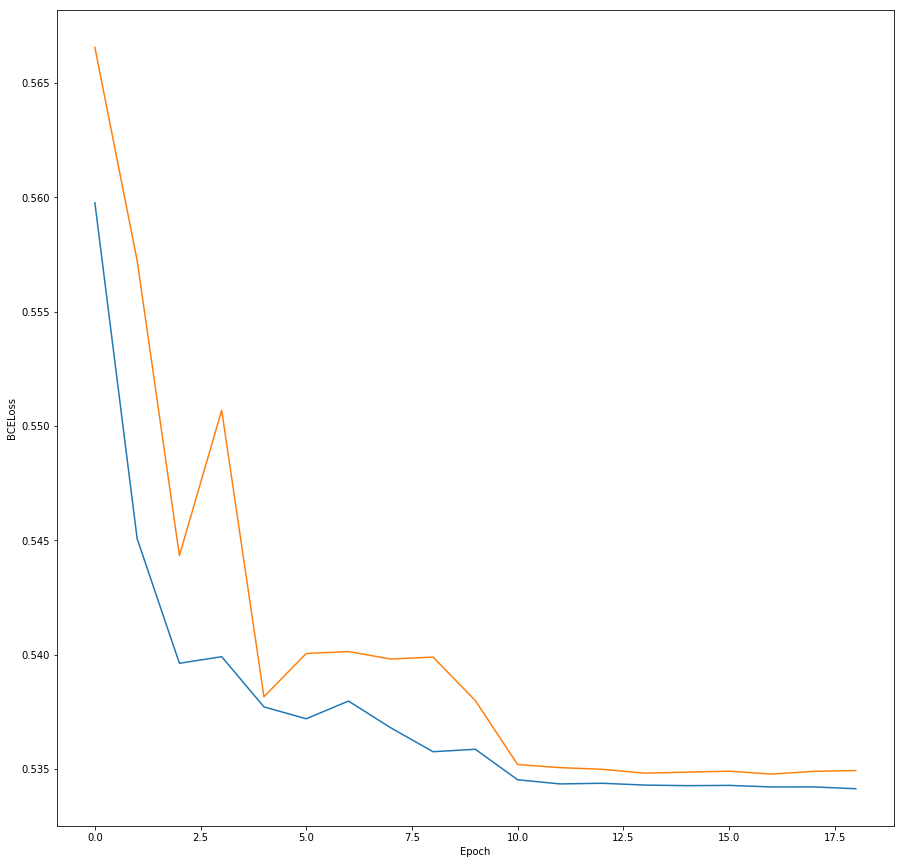

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))

plt.plot(np.arange(len(train_error)-1),train_error[:-1],label="Train loss")
plt.plot(np.arange(len(test_error)),test_error,label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("BCELoss")

plt.show()

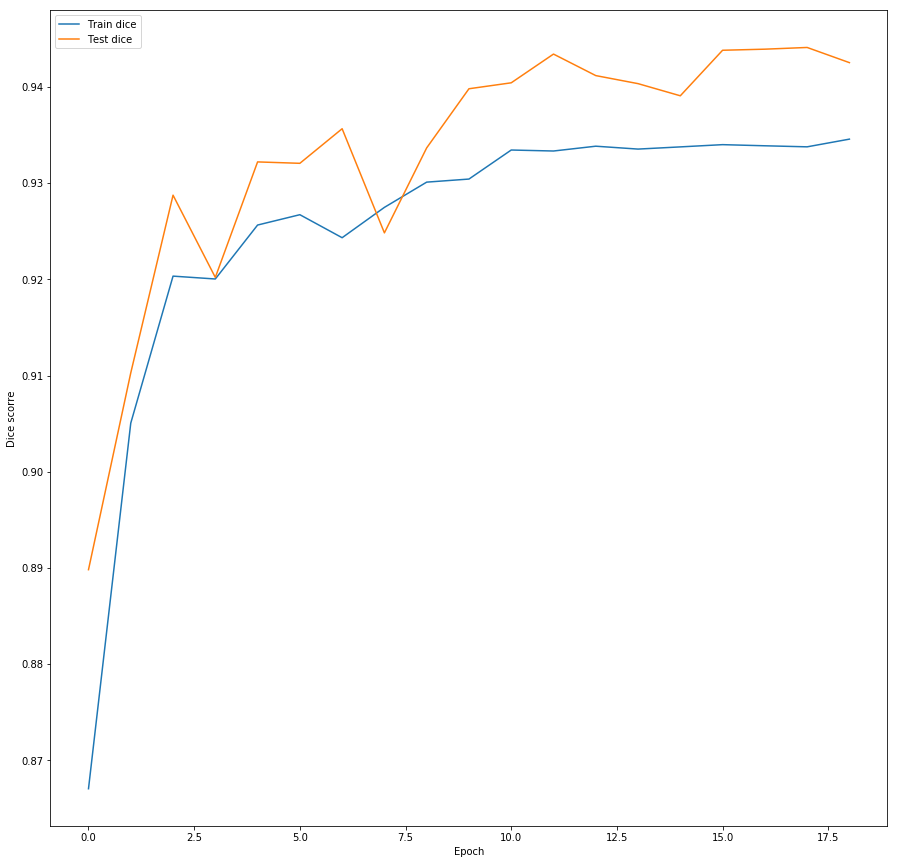

In [25]:
fig = plt.figure(figsize=(15,15))

plt.plot(np.arange(len(train_dice)-1),train_dice[:-1],label="Train dice")
plt.plot(np.arange(len(test_dice)),test_dice,label="Test dice")
plt.xlabel("Epoch")
plt.ylabel("Dice scorre")
plt.legend()

plt.show()

### Part 3. Bells and whistles

* Use at least 5 `albumentations` or `imgaug` augmentations on the data preparation step (up to 0.5 bonus points);


* Use `catalyst` or `kekas` to build the training pipeline (up to 0.5 bonus points);


* Deploy the web demo to play with on your own `dl2019fall-{lastname}.ml` domain.

  The demo earns 0.1 bonus points for each day it's alive in the range from **Oct 14 00:00 to Oct 27 23:59**.

  You can use https://github.com/nizhib/portrait-demo as a start point (up to 2 bonus points for 2-week streak).